In [38]:
import polars as pl
from matplotlib import pyplot as plt

import jax
from numpyro import distributions as dist
from jax import numpy as jnp

We will once again use the NHTSA non-fatal accident dataset. Our main research question is around horsepower - what is the overall distribution of horsepower for cars 
involved in crashes? Does a normal distribution approximate this distribution appropriately, or not?

Text(0.5, 1.0, 'Histogram of Engine Brake Horsepower (Lower Limit)')

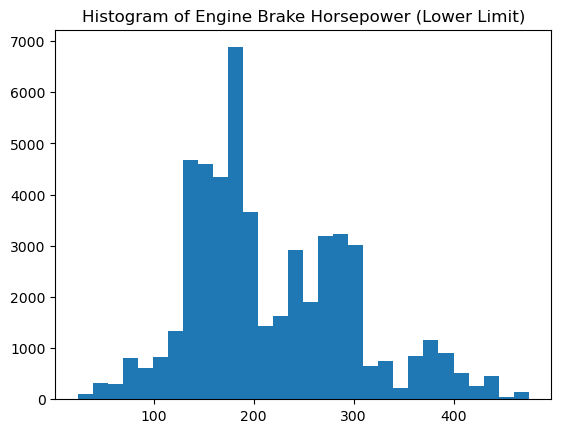

In [39]:
df = pl.read_csv("./data/CRSS2022CSV/vpicdecode.csv", ignore_errors=True)

# also filters out missing values
df = df.filter(
    pl.col("EngineBrakeHP_From").is_between(
        df["EngineBrakeHP_From"].quantile(0.005),
        df["EngineBrakeHP_From"].quantile(0.995),
    )
)
y = jnp.array(df["EngineBrakeHP_From"].to_numpy())


fig, ax = plt.subplots()
ax.hist(y, bins=30)
ax.set_title("Histogram of Engine Brake Horsepower (Lower Limit)")

Before looking at the data too closely, we will make some initial hypotheses.

First, I would expect $\sigma^2$ is roughly 25 and $\mu_0$ is about 150, i.e. The average car has about 150 horsepower, and I estimate that ~95% of cars have between 50 and 250 horsepower. 50HP is extremely low for a car, so this estimate seems off, but I also don't think a ton of cars have over 250 horsepower, since that gets into sports car territory. Let's plot these priors out.

The biggest observation is that our data is quite multimodal. There is a large chunk of cars with horsepowers around 120-180, then another spike from 240 to 300. Finally, 
from 350-400, there is yet another bump, albeit a small one. I suspect that correspond to cars/compacts, SUVS / trucks, and then sports cars, but I would need to dig into 
the data further to verify.

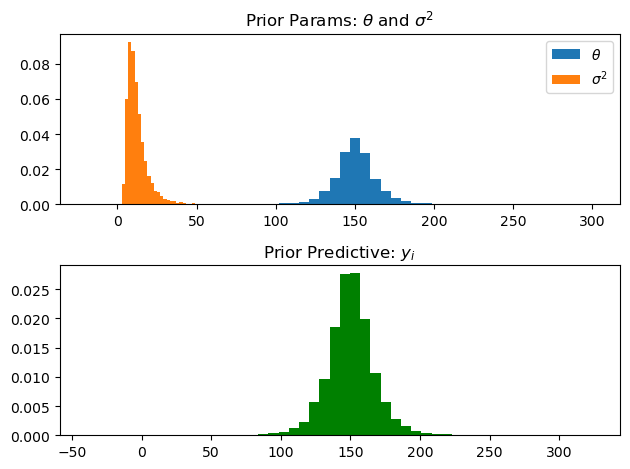

In [4]:
samp = 1e5
alpha = 5
beta = 50
mu_0 = 150
num_samples = 10000

rng_key = jax.random.key(17)
prior_sigma_samples = dist.InverseGamma(alpha, beta).sample(rng_key, (num_samples,))
prior_theta_samples = dist.Normal(mu_0, prior_sigma_samples).sample(rng_key)
prior_y_samples = dist.Normal(
    prior_theta_samples, jnp.sqrt(prior_sigma_samples)
).sample(rng_key)

fig, ax = plt.subplots(2)

ax[0].hist(prior_theta_samples, bins=50, label="$\\theta$", density=True)
ax[0].hist(prior_sigma_samples, bins=50, label="$\\sigma^2$", density=True)
ax[1].hist(prior_y_samples, bins=50, density=True, color="green")
ax[0].legend()
ax[0].set_title("Prior Params: $\\theta$ and $\\sigma^2$")
ax[1].set_title("Prior Predictive: $y_i$")
fig.tight_layout()

Looks ok. That's pretty low variability, but considering how little I know about cars, we'll stick with it.

Let's calculate our posteriors analytically. I copied my code from R and asked CoPilot to convert it to Python. It did pretty well.

In [5]:
def calc_posterior_precision(x, nu_0=2, kappa_0=1, sigma_0=50, mu_0=100):
    n = len(x)
    nu_n = n + nu_0

    t1 = nu_0 * sigma_0
    t2 = (kappa_0 * n * (mu_0 - jnp.mean(x)) ** 2) / (kappa_0 + n)
    t3 = (n - 1) * jnp.var(
        x, ddof=1
    )  # note that the var function uses the n-1 denominator

    sigma_n = (1 / nu_n) * (t1 + t2 + t3)

    alpha_n = nu_n / 2  # gamma param 1
    beta_n = (nu_n * sigma_n) / 2  # gamma param 2
    return alpha_n, beta_n


# since you must hold the normal conditional on the precision, need to provide sd_x
# and can only return draws of theta
def calc_posterior_mean(x, sd_x, kappa_0=1, mu_0=5):
    mu_n = (kappa_0 * mu_0 + len(x) * jnp.mean(x)) / (kappa_0 + len(x))
    kappa_n = kappa_0 + len(x)
    return mu_n, sd_x / jnp.sqrt(kappa_n)

Now we can take these functions and use them to sample from our distributions. We're using `numpyro` and `jax` for our sampling and array calculations, as this is probably what I'll do in the final project.

In [36]:
rng_key_2 = jax.random.key(51)

# get sigma samples
alpha_n, beta_n = calc_posterior_precision(
    df["EngineBrakeHP_From"].drop_nulls().to_numpy(), nu_0=mu_0
)
post_sigma_samples = jnp.sqrt(
    dist.InverseGamma(alpha_n, beta_n).sample(rng_key, (num_samples,))
)

# get theta samples conditional on the sigma samples
# "new_sd" is the same, since k_0 is 1
mu_n, new_sd = calc_posterior_mean(y, post_sigma_samples, mu_0=mu_0)
post_theta_samples = dist.Normal(mu_n, new_sd).sample(rng_key_2)

# get y samples conditional on the theta samples and sigma^2 samples
post_y_samples = dist.Normal(post_theta_samples, post_sigma_samples).sample(rng_key_2)

all_post_samples = jnp.stack(
    [post_theta_samples, post_sigma_samples, post_y_samples], axis=1
)
means = all_post_samples.mean(0)
bounds = jnp.quantile(all_post_samples, jnp.array([0.025, 0.975]), axis=0)

ci_estimates = jnp.stack([means, *bounds], axis=0).T
print(ci_estimates)

[[216.87027  216.17227  217.57108 ]
 [ 81.78695   81.28607   82.27969 ]
 [216.54042   57.060543 376.6512  ]]


| Parameter  | Estimate | Lower CI | Upper CI |
|------------|----------|----------|----------|
| $\theta$   | 216.87   | 216.17   | 217.57   |
| $\sigma^2$ | 81.79    | 81.29    | 82.28    |
| $y_j$      | 217.57   | 82.28    | 376.65   |

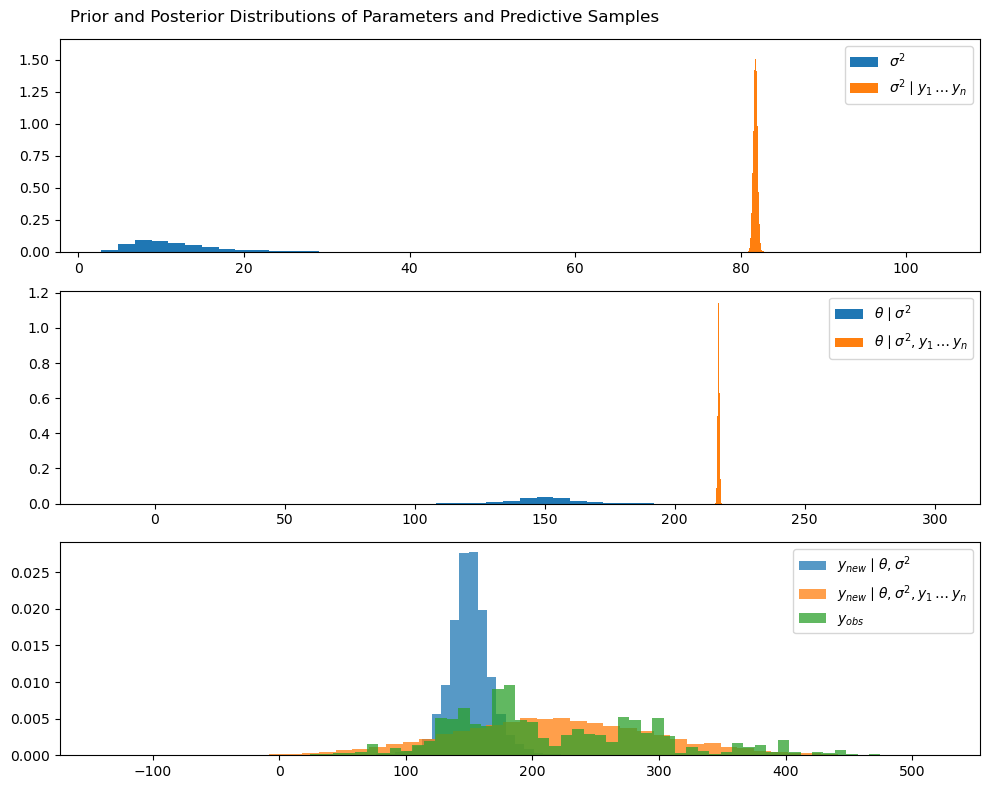

In [376]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=False, sharey=False, figsize=(10, 8))

ax[0].hist(prior_sigma_samples, bins=50, label="$\\sigma^2$", density=True)
ax[0].hist(
    post_sigma_samples, bins=50, label="$\\sigma^2 \\mid y_1 \\dots y_n$", density=True
)
ax[1].hist(
    prior_theta_samples, bins=50, label="$\\theta \\mid \\sigma^2$", density=True
)
ax[1].hist(
    post_theta_samples,
    bins=50,
    label="$\\theta \\mid \\sigma^2, y_1 \\dots y_n$",
    density=True,
)
ax[2].hist(
    prior_y_samples,
    bins=50,
    density=True,
    label="$y_{new} \\mid \\theta, \\sigma^2$",
    alpha=0.75,
)
ax[2].hist(
    post_y_samples,
    bins=50,
    density=True,
    label="$y_{new} \\mid \\theta, \\sigma^2, y_1 \\dots y_n$",
    alpha=0.75,
)
ax[2].hist(y, bins=50, density=True, label="$y_{obs}$", alpha=0.75)
for a in ax:
    a.legend()
fig.suptitle(
    "Prior and Posterior Distributions of Parameters and Predictive Samples",
    x=0.075,
    ha="left",
)
fig.tight_layout()

This plot reveals some interesting things. 

1) Our estimates of both $\sigma^2$ and $\theta$ became much tighter. This is to be expected, as our priors were weak before. 
2) Our prior estimates of $\sigma^2$ and $\theta$ were laughably far from the locations suggested by the data. In particular, our estimate for $\sigma^2$ was off by roughly a factor 4.
3) Our predictive distribution given our data and the empirical distribution look kind of close in terms of range, but are really far apart in terms of actual fit. Notably, the empirical distribution has multiple peaks that our normal model is not capturing.

Visually then, we would not say that our normal model is an exceptionally good fit, though it appropriately captures the range of the data, if not the distribution. This is mostly coming from the fact that vehicles have multiple classes that within themselves are probably normally distributed in horsepower. For example, SUVs have one grouping, trucks have another, sports cars have another, and compacts may be someplace else entirely. It is likely that horsepower is normally distributed conditional on the weight class of a car,
but in aggregate those distinctions are muddled.

How far off are the distributions? Let's compare the quantiles of our data and see how similar the quantiles of our predictive dist are compared to the empirical distribution.

Text(0.5, 1.0, 'QQ Plot of Horsepower (Lower Limit)')

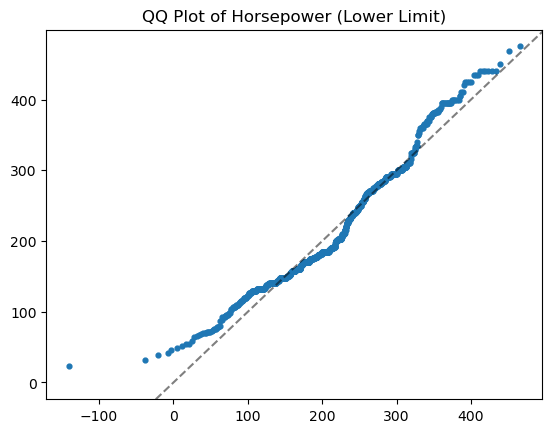

In [377]:
# get our quantile estimates
obs_quantiles = jnp.quantile(y, jnp.arange(0, 1, 0.001))
post_quantiles = jnp.quantile(post_y_samples, jnp.arange(0, 1, 0.001))

fig, ax = plt.subplots()
ax.scatter(post_quantiles, obs_quantiles, s=12)
ax.axline((0, 0), (1, 1), color="black", linestyle="--", alpha=0.5)
ax.set_title("QQ Plot of Horsepower (Lower Limit)")

There is a clear and obvious issue - at the lower end of the distribution, a normal distribution would predict some negative values given the variability in our data. 
However, it is impossible for a car to have 0 horsepower. The lower percentiles of cars all have higher than expected horsepower, if this distribution were truly normal. 
This is more akin to a truncated normal, in that there is a lower limit to vehicle horsepower. It could be that these are motorcycles or something of the sort, and not just cars. 
Next, the higher end of the distribution, though somewhat close to a normal, is ALSO higher than expected. This indicates that our horsepower distribution has a longer tail
than our normal model is capturing. This is all to say that althought the model is capturing the middle fairly well, there's clearly some gaps in how well the normal
model fits the observed data in this case. It would be more appropriate to have a model that is truncated at 0 and also allows for heavier tails, though the normal remains a 
good approximation if you squint hard enough.